## Fast.ai Deep Learning 1 Practice - MNIST SGD

This notebook is practice for Lesson 5 of the [Fast.ai](https://www.fast.ai) course. It uses a pickled version of the MNIST handwritten digit dataset.

In [1]:
%matplotlib inline
from fastai.basics import *

In [2]:
path = Path('/media/veracrypt3/Cloud/Datasets/')

In [3]:
# can open directly with gzip
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    # the lone underscore essentially means that input isn't important, or we don't care about it
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)

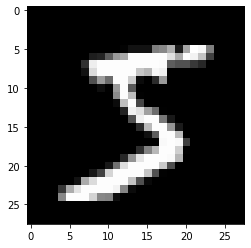

In [4]:
plt.imshow(x_train[0].reshape((28, 28)), cmap='gray')
x_train.shape

In [5]:
# currently inputs are numpy arrays, but need to make them tensors
# can just map them to tensors using torch.tensor
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))
n, c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In [6]:
bs=64

# can use TensorDataset from pytorch to create dataset from 2 tensors.
# looks like a list of (x, y) tuples
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [7]:
x, y = next(iter(data.train_dl))
x.shape, y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [9]:
# create nn.Module via subclassing
# main thing is you need to override the constructor, dunder init

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)
        
    def forward(self, xb):
        return self.lin(xb)

In [10]:
# need to load model onto GPU manually
model = Mnist_Logistic().cuda()

In [11]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [12]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [13]:
model(x).shape

torch.Size([64, 10])

In [15]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [16]:
lr = 2e-2

In [17]:
loss_func = nn.CrossEntropyLoss()

In [18]:
def update(x, y, lr):
    wd = 1e-5
    # calling model instead of x@a
    y_hat = model(x)
    # weight decay
    w2 = 0.
    
    for p in model.parameters(): w2 += (p**2).sum()
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [19]:
losses = [update(x, y, lr) for x, y in data.train_dl]

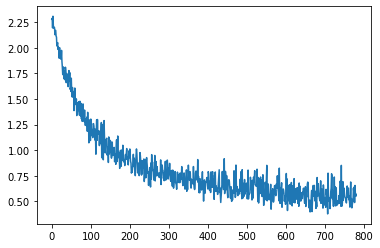

In [20]:
plt.plot(losses);

In [21]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)
    
    # technically a neural net
    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [22]:
model = Mnist_NN().cuda()

In [23]:
losses = [update(x, y, lr) for x, y in data.train_dl]

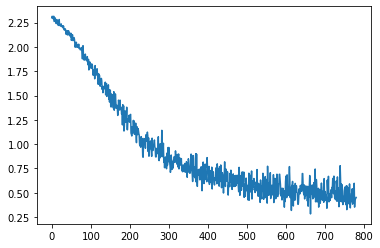

In [24]:
plt.plot(losses);

In [25]:
model = Mnist_NN().cuda()

In [26]:
def update(x, y, lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [27]:
losses = [update(x, y, lr) for x, y in data.train_dl]

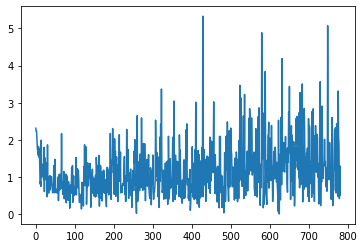

In [28]:
# shows a lot of divergence
plt.plot(losses);

In [29]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


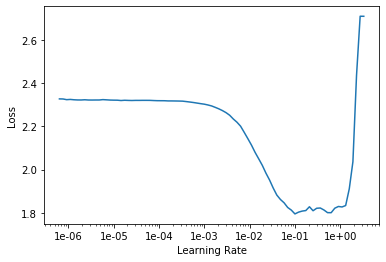

In [30]:
learn.lr_find()
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.156465,0.131730,0.961400,00:02


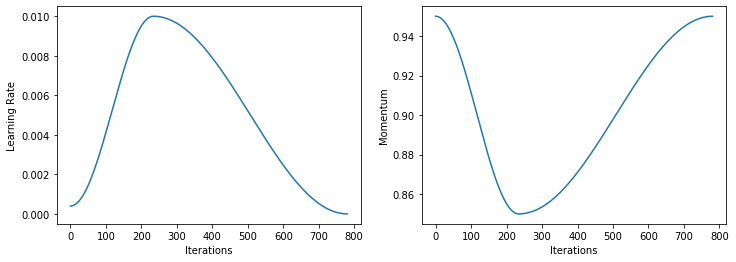

In [33]:
learn.recorder.plot_lr(show_moms=True)

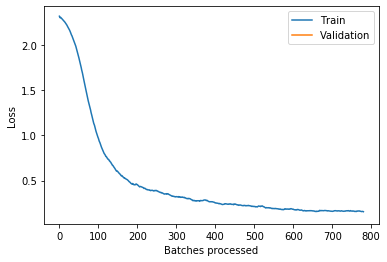

In [34]:
learn.recorder.plot_losses()